# Natural language inference: task and datasets

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2022"

## Contents

1. [Overview](#Overview)
1. [Our version of the task](#Our-version-of-the-task)
1. [Primary resources](#Primary-resources)
1. [Set-up](#Set-up)
1. [SNLI](#SNLI)
    1. [SNLI properties](#SNLI-properties)
    1. [Working with SNLI](#Working-with-SNLI)
1. [MultiNLI](#MultiNLI)
    1. [MultiNLI properties](#MultiNLI-properties)
    1. [Working with MultiNLI](#Working-with-MultiNLI)
    1. [Annotated MultiNLI subsets](#Annotated-MultiNLI-subsets)
1. [Adversarial NLI](#Adversarial-NLI)
    1. [Adversarial NLI properties](#Adversarial-NLI-properties)
    1. [Working with Adversarial NLI](#Working-with-Adversarial-NLI)
1. [Other NLI datasets](#Other-NLI-datasets)

## Overview

Natural Language Inference (NLI) is the task of predicting the logical relationships between words, phrases, sentences, (paragraphs, documents, ...). Such relationships are crucial for all kinds of reasoning in natural language: arguing, debating, problem solving, summarization, and so forth.

[Dagan et al. (2006)](https://u.cs.biu.ac.il/~nlp/RTE1/Proceedings/dagan_et_al.pdf), one of the foundational papers on NLI (also called Recognizing Textual Entailment; RTE), make a case for the generality of this task in NLU:

> It seems that major inferences, as needed by multiple applications, can indeed be cast in terms of textual entailment. For example, __a QA system__ has to identify texts that entail a hypothesized answer. [...] Similarly, for certain __Information Retrieval__ queries the combination of semantic concepts and relations denoted by the query should be entailed from relevant retrieved documents. [...] In __multi-document summarization__ a redundant sentence, to be omitted from the summary, should be entailed from other sentences in the summary. And in __MT evaluation__ a correct translation should be semantically equivalent to the gold standard translation, and thus both translations should entail each other. Consequently, we hypothesize that textual entailment recognition is a suitable generic task for evaluating and comparing applied semantic inference models. Eventually, such efforts can promote the development of entailment recognition "engines" which may provide useful generic modules across applications.

## Our version of the task

Our NLI data will look like this:

| Premise | Relation        | Hypothesis |
|:--------|:---------------:|:------------|
| turtle  | contradiction | linguist   |
| A turtled danced | entails | A turtle moved |
| Every reptile danced | entails | Every turtle moved |
| Some turtles walk | contradicts | No turtles move |
| James Byron Dean refused to move without blue jeans | entails | James Dean didn't dance without pants |

In the [word-entailment bakeoff](hw_wordentail.ipynb), we study a special case of this where the premise and hypothesis are single words. This notebook begins to introduce the problem of NLI more fully.

## Primary resources

We're going to focus on three NLI corpora:

* [The Stanford Natural Language Inference corpus (SNLI)](https://nlp.stanford.edu/projects/snli/)
* [The Multi-Genre NLI Corpus (MultiNLI)](https://www.nyu.edu/projects/bowman/multinli/)
* [The Adversarial NLI Corpus (ANLI)](https://github.com/facebookresearch/anli)

The first was collected by a group at Stanford, led by [Sam Bowman](https://www.nyu.edu/projects/bowman/), and the second was collected by a group at NYU, also led by [Sam Bowman](https://www.nyu.edu/projects/bowman/). Both have the same format and were crowdsourced using the same basic methods. However, SNLI is entirely focused on image captions, whereas MultiNLI includes a greater range of contexts.

The third corpus was collected by a group at Facebook AI and UNC Chapel Hill. The team's goal was to address the fact that datasets like SNLI and MultiNLI seem to be artificially easy – models trained on them can often surpass stated human performance levels but still fail on examples that are simple and intuitive for people. The dataset is "Adversarial" because the annotators were asked to try to construct examples that fooled strong models but still passed muster with other human readers.

This notebook presents tools for working with these corpora. The [second notebook in the unit](nli_02_models.ipynb) concerns models of NLI.

## Set-up

* As usual, you need to be fully set up to work with [the CS224u repository](https://github.com/cgpotts/cs224u/).

* If you haven't already, download [the course data](http://web.stanford.edu/class/cs224u/data/data.tgz), unpack it, and place it in the directory containing the course repository – the same directory as this notebook. (If you want to put it somewhere else, change `DATA_HOME` below.)

In [1]:
import nli
import os
import pandas as pd
import random

In [2]:
from datasets import load_dataset

In [3]:
DATA_HOME = os.path.join("data", "nlidata")

ANNOTATIONS_HOME = os.path.join(DATA_HOME, "multinli_1.0_annotations")

## SNLI

### SNLI properties

For SNLI (and MultiNLI), MTurk annotators were presented with premise sentences and asked to produce new sentences that entailed, contradicted, or were neutral with respect to the premise. A subset of the examples were then validated by an additional four MTurk annotators.

* All the premises are captions from the [Flickr30K corpus](http://shannon.cs.illinois.edu/DenotationGraph/).


* Some of the sentences rather depressingly reflect stereotypes ([Rudinger et al. 2017](https://www.aclweb.org/anthology/W17-1609)).


* 550,152 train examples; 10K dev; 10K test


* Mean length in tokens:
  * Premise: 14.1
  * Hypothesis: 8.3

* Clause-types
  * Premise S-rooted: 74%
  * Hypothesis S-rooted: 88.9%


* Vocab size: 37,026


* 56,951 examples validated by four additional annotators
  * 58.3% examples with unanimous gold label
  * 91.2% of gold labels match the author's label
  * 0.70 overall Fleiss kappa


* Top scores currently around 90%.  

### Working with SNLI

In [4]:
snli = load_dataset("snli")

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Dataset snli downloaded and prepared to /Users/xianbing/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset has three splits:

In [5]:
snli.keys()

dict_keys(['test', 'train', 'validation'])

The class `nli.NLIReader` is used by all the readers discussed here.

Because the datasets are so large, it is often useful to be able to randomly sample from them. This is supported with the keyword argument `samp_percentage`. For example, the following samples approximately 10% of the examples from the SNLI training set:

In [6]:
nli.NLIReader(snli['train'], samp_percentage=0.10, random_state=42)

"NLIReader({'splits': (Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 550152
}),), 'filter_unlabeled': True, 'samp_percentage': 0.1, 'random_state': 42})

The precise number of examples will vary somewhat because of the way the sampling is done. (Here, we choose efficiency over precision in the number of cases we return; see the implementation for details.)

All of the readers have a `read` method that yields `NLIExample` example instances. For SNLI, these have the following attributes:

* __label__: `str`
* __premise__: `str`
* __hypothesis__: `str`

Note: the original SNLI distribution includes a number of other valuable fields, including identifiers for the original caption in the [Flickr 30k corpus](http://shannon.cs.illinois.edu/DenotationGraph/), parses for the examples, and annotation distributions for the validation set. Perhaps someone could update [the dataset on Hugging Face](https://huggingface.co/datasets/snli) to provide access to this information!

The following creates the label distribution for the training data:

In [7]:
snli_labels = pd.Series(
    [ex.label for ex in nli.NLIReader(
        snli['train'], filter_unlabeled=False).read()])

snli_labels.value_counts()

entailment       183416
contradiction    183187
neutral          182764
-                   785
dtype: int64

In [8]:
snli_labels

0               neutral
1         contradiction
2            entailment
3               neutral
4            entailment
              ...      
550147    contradiction
550148          neutral
550149          neutral
550150    contradiction
550151       entailment
Length: 550152, dtype: object

Use `filter_unlabeled=True` (the default) to silently drop the examples for which `gold_label` is `-`.

Let's look at a specific example in some detail:

In [9]:
snli_iterator = iter(nli.NLIReader(snli['train']).read())

In [10]:
snli_ex = next(snli_iterator)

In [11]:
print(snli_ex)

"NLIExample({'premise': 'A person on a horse jumps over a broken down airplane.', 'hypothesis': 'A person is training his horse for a competition.', 'label': 'neutral'})


## MultiNLI

### MultiNLI properties


* Train premises drawn from five genres: 
  1. Fiction: works from 1912–2010 spanning many genres
  1. Government: reports, letters, speeches, etc., from government websites
  1. The _Slate_ website
  1. Telephone: the Switchboard corpus
  1. Travel: Berlitz travel guides


* Additional genres just for dev and test (the __mismatched__ condition): 
  1. The 9/11 report
  1. Face-to-face: The Charlotte Narrative and Conversation Collection
  1. Fundraising letters
  1. Non-fiction from Oxford University Press
  1. _Verbatim_ articles about linguistics


* 392,702 train examples; 20K dev; 20K test


* 19,647 examples validated by four additional annotators
  * 58.2% examples with unanimous gold label
  * 92.6% of gold labels match the author's label


* Test-set labels available as a Kaggle competition.  

  * Top matched scores currently around 0.81.
  * Top mismatched scores currently around 0.83.

### Working with MultiNLI

In [12]:
mnli = load_dataset("multi_nli")

Using custom data configuration default


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Dataset multi_nli downloaded and prepared to /Users/xianbing/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

For MultiNLI, we have the following splits: 

* `train`
* `validation_matched`
* `validation_mismatched`

In [13]:
mnli.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched'])

The MultiNLI test sets are available on Kaggle ([matched version](https://www.kaggle.com/c/multinli-matched-open-evaluation) and [mismatched version](https://www.kaggle.com/c/multinli-mismatched-open-evaluation)).

The interface to these is the same as for the SNLI readers:

In [13]:
nli.NLIReader(mnli['train'], samp_percentage=0.10, random_state=42)

"NLIReader({'splits': (Dataset({
    features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
    num_rows: 392702
}),), 'filter_unlabeled': True, 'samp_percentage': 0.1, 'random_state': 42})

The `NLIExample` instances for MultiNLI have nearly all the attributes that SNLI is supposed to have!

* __promptID__: `str`
* __label__: `str`
* __pairID__: `str`
* __premise__: `str`
* __premise_binary_parse__: `nltk.tree.Tree`
* __premise_parse__: `nltk.tree.Tree`
* __hypothesis__: `str`
* __hypothesis_binary_parse__: `nltk.tree.Tree`
* __hypothesis_parse__: `nltk.tree.Tree`

The only field that is unfortunately missing is  __annotator_labels__, which gives all five labels chosen by annotators for the two dev splits. Perhaps someone could [create a PR to bring these fields back in](https://huggingface.co/datasets/multi_nli)!

The full label distribution for the train split:

In [14]:
multinli_labels = pd.Series(
    [ex.label for ex in nli.NLIReader(
        mnli['validation_mismatched'], filter_unlabeled=False).read()])

multinli_labels.value_counts()

entailment       3463
contradiction    3240
neutral          3129
dtype: int64

No examples in the MultiNLI train set lack a gold label. The original corpus distribution does contain some unlabeled examples in its dev-sets, but those seem to have been removed in the Hugging Face distribution. As a result, the value of the `filter_unlabeled` parameter has no effect for `mnli`.

Let's look at a specific example:

In [15]:
mnli_iterator = iter(nli.NLIReader(mnli['train']).read())

In [17]:
mnli_ex = next(mnli_iterator)

As you can see, there are three versions of the premise and hypothesis sentences:

1. Regular string representations of the data
2. Unlabeled binary parses
3. Labeled parses

In [18]:
mnli_ex.premise

'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him'

The binary parses lack node labels; so that we can use `nltk.tree.Tree` with them, the label `X` is added to all of them:

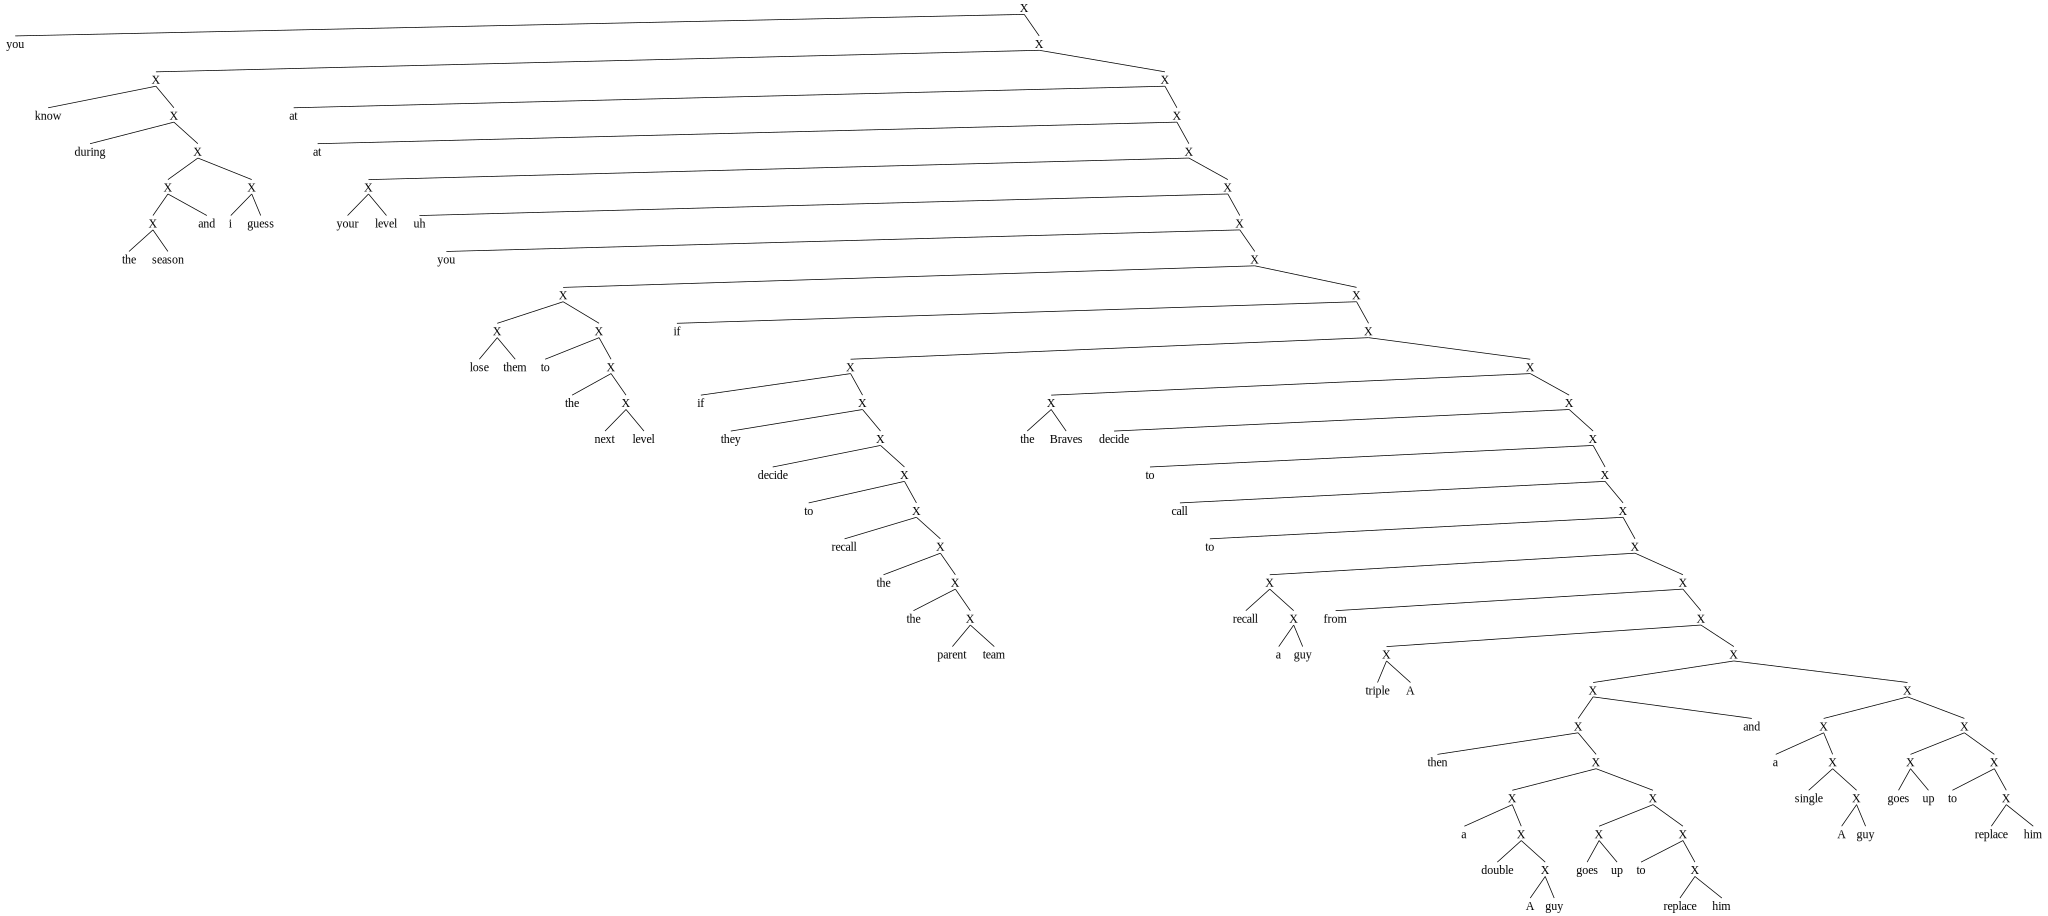

In [20]:
mnli_ex.premise_binary_parse

Here's the full parse tree with syntactic categories:

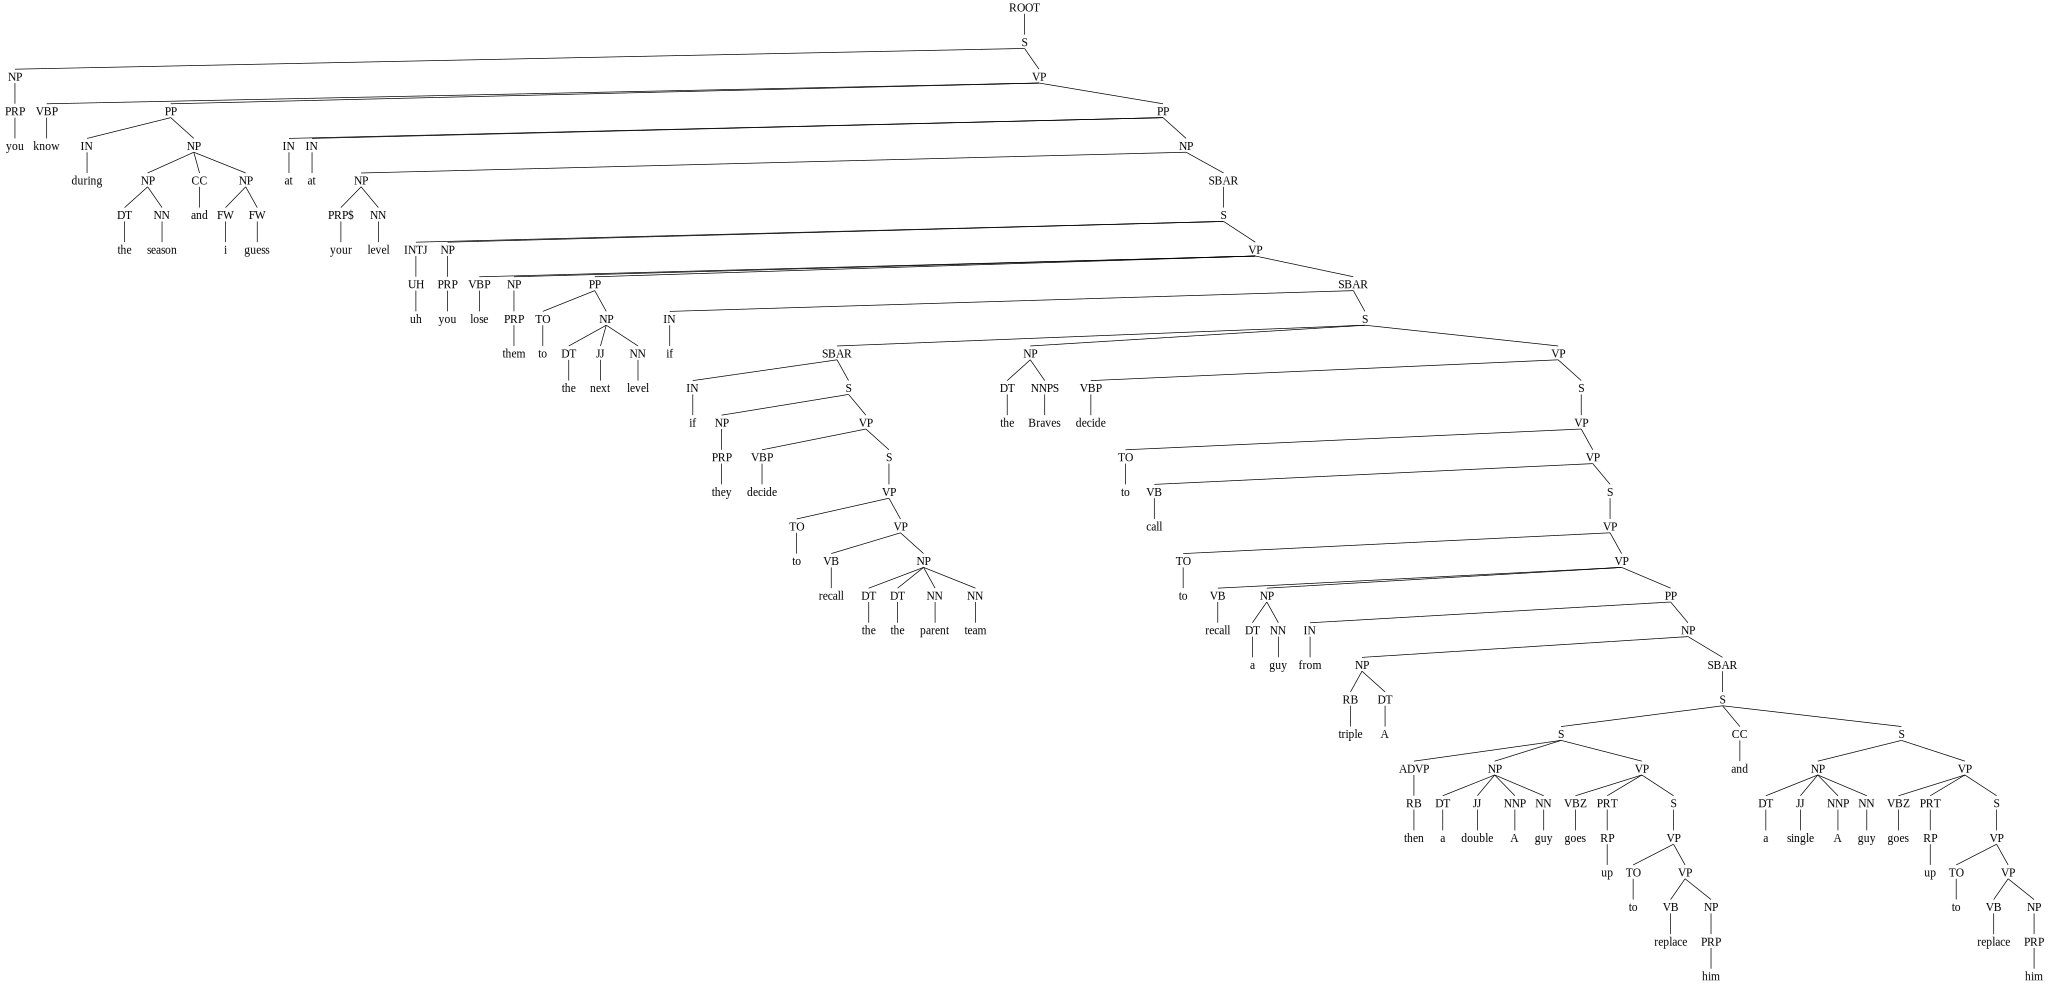

In [21]:
mnli_ex.premise_parse

The leaves of either tree are tokenized versions of them:

In [22]:
mnli_ex.premise_parse.leaves()

['you',
 'know',
 'during',
 'the',
 'season',
 'and',
 'i',
 'guess',
 'at',
 'at',
 'your',
 'level',
 'uh',
 'you',
 'lose',
 'them',
 'to',
 'the',
 'next',
 'level',
 'if',
 'if',
 'they',
 'decide',
 'to',
 'recall',
 'the',
 'the',
 'parent',
 'team',
 'the',
 'Braves',
 'decide',
 'to',
 'call',
 'to',
 'recall',
 'a',
 'guy',
 'from',
 'triple',
 'A',
 'then',
 'a',
 'double',
 'A',
 'guy',
 'goes',
 'up',
 'to',
 'replace',
 'him',
 'and',
 'a',
 'single',
 'A',
 'guy',
 'goes',
 'up',
 'to',
 'replace',
 'him']

### Annotated MultiNLI subsets

MultiNLI includes additional annotations for a subset of the dev examples. The goal is to help people understand how well their models are doing on crucial NLI-related linguistic phenomena.

In [24]:
matched_ann_filename = os.path.join(
    ANNOTATIONS_HOME,
    "multinli_1.0_matched_annotations.txt")

mismatched_ann_filename = os.path.join(
    ANNOTATIONS_HOME,
    "multinli_1.0_mismatched_annotations.txt")

In [26]:
def view_random_example(annotations, random_state=42):
    random.seed(random_state)
    ann_ex = random.choice(list(annotations.items()))
    pairid, ann_ex = ann_ex
    ex = ann_ex['example']
    print("pairID: {}".format(pairid))
    print(ann_ex['annotations'])
    print(ex.premise)
    print(ex.label)
    print(ex.hypothesis)

In [27]:
matched_ann = nli.read_annotated_subset(
    matched_ann_filename, 
    mnli['validation_matched'])

In [29]:
view_random_example(matched_ann, random_state=23)

pairID: 132936n
['#NEGATION', '#COREF']
This one-at-a-time, uncoordinated series of regulatory requirements for the power industry is not the optimal approach for the environment, the power generation sector, or American consumers.
entailment
It is not the optimal approach.


## Adversarial NLI

### Adversarial NLI properties

The ANLI dataset was created in response to evidence that datasets like SNLI and MultiNLI are artificially easy for modern machine learning models to solve. The team sought to tackle this weakness head-on, by designing a crowdsourcing task in which annotators were explicitly trying to confuse state-of-the-art models. In broad outline, the task worked like this:

1. The crowdworker is presented with a premise (context) text and asked to construct a hypothesis sentence that entails, contradicts, or is neutral with respect to that premise. (The actual wording is more informal, along the lines of the SNLI/MultiNLI task).

1. The crowdworker submits a hypothesis text.

1. The premise/hypothesis pair is  fed to a trained model that makes a prediction about the correct NLI label.

1. If the model's prediction is correct, then the crowdworker loops back to step 2 to try again. If the model's prediction is incorrect, then the example is validated by different crowdworkers.

The dataset consists of three rounds, each involving a different model and a different set of sources for the premise texts:

| Round  | Model       | Training data              | Context sources  | 
|:------:|:------------|:---------------------------|:-----------------|
| 1 |  [BERT-large](https://www.aclweb.org/anthology/N19-1423/) | SNLI + MultiNLI | Wikipedia |
| 2      |  [ROBERTa](https://arxiv.org/abs/1907.11692)    | SNLI + MultiNLI + [NLI-FEVER](https://github.com/easonnie/combine-FEVER-NSMN/blob/master/other_resources/nli_fever.md) + Round 1 | Wikipedia        |
| 3      |  [ROBERTa](https://arxiv.org/abs/1907.11692)    | SNLI + MultiNLI + [NLI-FEVER](https://github.com/easonnie/combine-FEVER-NSMN/blob/master/other_resources/nli_fever.md) + Round 2 | Various          |

Each round has train/dev/test splits. The sizes of these splits and their label distributions are calculated just below.

The [project README](https://github.com/facebookresearch/anli/blob/master/README.md) seeks to establish some rules for how the rounds can be used for training and evaluation.

### Working with Adversarial NLI

In [30]:
anli = load_dataset("anli")

Generating train_r1 split:   0%|          | 0/16946 [00:00<?, ? examples/s]

Generating dev_r1 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test_r1 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_r2 split:   0%|          | 0/45460 [00:00<?, ? examples/s]

Generating dev_r2 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test_r2 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_r3 split:   0%|          | 0/100459 [00:00<?, ? examples/s]

Generating dev_r3 split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Generating test_r3 split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Dataset anli downloaded and prepared to /Users/xianbing/.cache/huggingface/datasets/anli/plain_text/0.1.0/aabce88453b06dff21c201855ea83283bab0390bff746deadb30b65695755c0b. Subsequent calls will reuse this data.


  0%|          | 0/9 [00:00<?, ?it/s]

For ANLI, we have a lot of options. Because it is distributed in three rounds, and the rounds can be used independently or pooled:

In [32]:
anli.keys()

dict_keys(['train_r1', 'dev_r1', 'test_r1', 'train_r2', 'dev_r2', 'test_r2', 'train_r3', 'dev_r3', 'test_r3'])

Here is the fully pooled train setting:

In [33]:
anli_pooled_reader = nli.NLIReader(
    anli['train_r1'], anli['train_r2'], anli['train_r3'],
    filter_unlabeled=False)

In [34]:
anli_pooled_labels = pd.Series([ex.label for ex in anli_pooled_reader.read()])

anli_pooled_labels.value_counts()

neutral          68789
entailment       52111
contradiction    41965
dtype: int64

In [35]:
for rounds in ((1,), (2,), (3,), (1,2,3)):
    splits = [anli['train_r{}'.format(i)] for i in rounds]            
    count = len(list(nli.NLIReader(*splits).read()))
    print("R{0:}: {1:,}".format(rounds, count))

R(1,): 16,946
R(2,): 45,460
R(3,): 100,459
R(1, 2, 3): 162,865


The above figures correspond to those in Table 2 of the paper.

Here is a summary of what `NLIExample` instances offer for this corpus:

* __uid__: a unique identifier; akin to `pairID` in SNLI/MultiNLI 
* __premise__: the premise; corresponds to `sentence1` in SNLI/MultiNLI
* __hypothesis__: the hypothesis; corresponds to `sentence2` in SNLI/MultiNLI
* __label__: the gold label; corresponds to `gold_label` in SNLI/MultiNLI
* __reason__: a crowdworker's free-text hypothesis about why the model made an incorrect prediction for the current __context__/__hypothesis__ pair

The ANLI distribution contains additional fields that are unfortunately left out of the Hugging Face distribution:

* __model_label__: the label predicted by the model used in the current round
* __emturk__: for dev (and test), this is `True` if the annotator contributed only dev (test) exmples, else `False`; in turn, it is `False` for all train examples.
* __genre__: the source for the __context__ text
* __tag__: information about the round and train/dev/test classification

As with the other datasets, it would be a wonderful service to the field to [improve the interface](https://huggingface.co/datasets/anli)!

In [31]:
anli_ex = next(iter(nli.NLIReader(anli['dev_r3']).read()))

In [32]:
anli_ex

"NLIExample({'uid': '50a5d4bc-bb8b-44f9-ba07-95dfaf5536ab', 'premise': 'one of the orders issued by Ochola in April Login to license this image from 1$. In short At Kira Road police station, the photocopier business has moved behind the station, far away from the prying eyes of those passing on the road to Bukoto while at Old Kampala Police station, clients are now buying the forms across the road.', 'hypothesis': 'The decision to move the photocopier business was done for privacy reasons.', 'label': 'entailment', 'reason': 'I made an obvious inference from the text that a human would understand. This is not something that can be found by literally reading the words on the page.'})

## Other NLI datasets

There are a lot of NLI datasets available from the Hugging Face `datasets` library. [Here's a link to the full index](https://huggingface.co/datasets?task_ids=task_ids:natural-language-inference), and here are some highlights:

* [The SemEval 2014 semantic relatedness shared task](http://alt.qcri.org/semeval2014/task1/) used an NLI dataset called [Sentences Involving Compositional Knowledge (SICK)](http://alt.qcri.org/semeval2014/task1/index.php?id=data-and-tools). HF: https://huggingface.co/datasets/sick

* [XNLI](https://github.com/facebookresearch/XNLI) is a multilingual collection of test sets derived from MultiNLI. HF: https://huggingface.co/datasets/xnli

* [Turkish NLI](https://github.com/boun-tabi/NLI-TR) provides human-validated machine-translated versions of SNLI and MultiNLI. These seem not to show up in the above index, but they can be accessed via:
   ```
   snli_tr_dataset = load_dataset('nli_tr', 'snli_tr')
   multinli_tr_dataset = load_dataset('nli_tr', 'multinli_tr')
   ```
   
And here are some tips on additional NLI datasets that aren't yet on Hugging Face:

* [The FraCaS textual inference test suite](http://www-nlp.stanford.edu/~wcmac/downloads/) is a smaller, hand-built dataset that is great for evaluating a model's ability to handle complex logical patterns.

* [SemEval 2013](https://www.cs.york.ac.uk/semeval-2013/) had a wide range of interesting data sets for NLI and related tasks.

* [The SemEval 2014 semantic relatedness shared task](http://alt.qcri.org/semeval2014/task1/) used an NLI dataset called [Sentences Involving Compositional Knowledge (SICK)](http://alt.qcri.org/semeval2014/task1/index.php?id=data-and-tools).

* [MedNLI](https://physionet.org/physiotools/mimic-code/mednli/) is specialized to the medical domain, using data derived from [MIMIC III](https://mimic.physionet.org).

* [Diverse Natural Language Inference Collection (DNC)](http://decomp.io/projects/diverse-natural-language-inference/) transforms existing annotations from other tasks into NLI problems for a diverse range of reasoning challenges.

* [SciTail](http://data.allenai.org/scitail/) is an NLI dataset derived from multiple-choice science exam questions and Web text.

* [NLI Style FEVER](https://github.com/easonnie/combine-FEVER-NSMN/blob/master/other_resources/nli_fever.md) is a version of [the FEVER dataset](http://fever.ai) put into a standard NLI format. It was used by the Adversarial NLI team to train models for their annotation round 2.

* [OCNLI: Original Chinese Natural Language Inference](https://github.com/CLUEbenchmark/OCNLI): A large, high-quality MNLI-style NLI dataset for Mandarin.